The Kaplan–Meier estimator, also known as the product limit estimator, is a non-parametric statistic used to estimate the survival function from lifetime data. In medical research, it is often used to measure the fraction of patients living for a certain amount of time after treatment. In other fields, Kaplan–Meier estimators may be used to measure the length of time people remain unemployed after a job loss, the time-to-failure of machine parts, or how long fleshy fruits remain on plants before they are removed by frugivores.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sksurv.datasets import load_flchain
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.util import Surv
from sksurv.metrics import (concordance_index_censored,
                            concordance_index_ipcw,
                            cumulative_dynamic_auc)

plt.rcParams['figure.figsize'] = [7.2, 4.8]

In [23]:
x, y = load_flchain()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [24]:
num_columns = ['age', 'creatinine', 'kappa', 'lambda']

imputer = SimpleImputer().fit(x_train.loc[:, num_columns])
x_train = imputer.transform(x_train.loc[:, num_columns])
x_test = imputer.transform(x_test.loc[:, num_columns])

In [25]:
y_events = y_train[y_train['death']]
train_min, train_max = y_events["futime"].min(), y_events["futime"].max()

y_events = y_test[y_test['death']]
test_min, test_max = y_events["futime"].min(), y_events["futime"].max()

assert train_min <= test_min < test_max < train_max, \
    "time range or test data is not within time range of training data."

In [26]:
times = np.percentile(y["futime"], np.linspace(5, 81, 15))
print(times)

[ 470.3        1259.         1998.         2464.82428571 2979.
 3401.         3787.99857143 4051.         4249.         4410.17285714
 4543.         4631.         4695.         4781.         4844.        ]


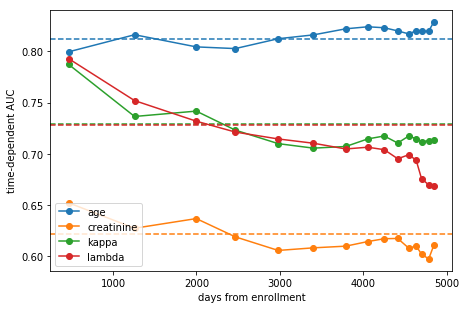

In [27]:
def plot_cumulative_dynamic_auc(risk_score, label, color=None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)

    plt.plot(times, auc, marker="o", color=color, label=label)
    plt.xlabel("days from enrollment")
    plt.ylabel("time-dependent AUC")
    plt.axhline(mean_auc, color=color, linestyle="--")
    plt.legend()

    
for i, col in enumerate(num_columns):
    plot_cumulative_dynamic_auc(x_test[:, i], col, color="C{}".format(i))
    ret = concordance_index_ipcw(y_train, y_test, x_test[:, i], tau=times[-1])

In [ ]:
!pip install lifelines

The estimator of the survival function S(t) (the probability that life is longer than t is given by:

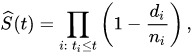

with ti a time when at least one event happened, di the number of events (e.g., deaths) that happened at time ti and ni the individuals known to have survived (have not yet had an event or been censored) up to time ti.

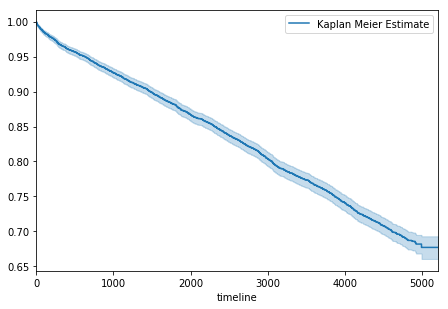

In [28]:
## Lets create an overall KaplanMeier curve
import lifelines

from lifelines import KaplanMeierFitter

durations = y_train['futime'] ## Time to event data of censored and event data
event_observed = y_train['death']  ## It has the churned (1) and censored is (0)

## create a kmf object as km
km = KaplanMeierFitter() ## instantiate the class to create an object

## Fit the data into the model
km.fit(durations, event_observed,label='Kaplan Meier Estimate')

## Create an estimate
km.plot()

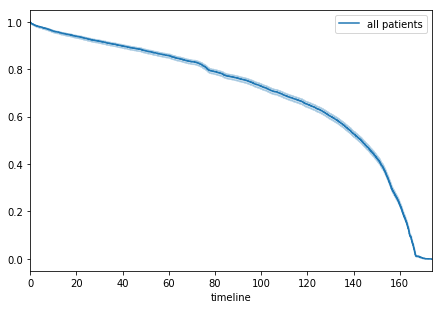

In [29]:
# Duration of patient following in months
T = [i / 30. for i in y_train["futime"]]
# Observation of death in boolean
# True for observed event (death);
# else False (this includes death not observed; death by other causes)
C = [True if i is not pd.NaT else False for i in y_train["death"]]

fitter = KaplanMeierFitter()
fitter.fit(T, event_observed=C, label="all patients")
fitter.plot(show_censors=True)